# Goal of the project

The goal of this project is to control a 2D quadrotor to reach a target while avoiding obstacles using a learned policy. You wil have to create your own Custom environment using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/) library and train a RL agent using PPO.

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
np.random.seed(27)



## 2D quadrotor

The quadrotor is depicted in the following figure
<center>
<img src='quadrotor.png' width="500">
</center>


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [13]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("quadrotor.LENGTH  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)
print("gravity constant =", quadrotor.GRAVITY_CONSTANT)

Mass    = 0.5
quadrotor.LENGTH  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2
gravity constant = 9.81


The goal of this project is to learn a policy that can move the robot from any point to the red dot ($x^{\star} = [2, 0, 0, 0, 0, 0]^T$) while avoiding these obstacles. The obstacles are represented by the black circles in the animation. You can check if the drone is in collision with an obstacle using the function ```quadrotor.check_collision```. 

## Create a RL environment
Using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/), create a [custom RL environment](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html) environment. You will have to follow the following steps:

1. Implement a step function than contrains the dynamics (you are free to use the ```quadrotor.next_state```) and a reward function. To speed-up the training, make sure to add a gravity compensation term in your dynamics (i.e. the drone should stay in place when the policy outputs zeros).
   The reward should be made of three terms:
   
- A positive term to incentivize the quadrotor to reach the target. You can start with a reward bounded between 0 and 1, e.g.
 $\operatorname{exp}(-\frac{1}{2} (x - x^{\star})Q(x - x^{\star}) -\frac{1}{2} (u - u_{\text{gravity}})R(u - u_{\text{gravity}}))$   

   
- A large negative penality(e.g. -100)  if the robot get out of the following bounds:
$ p_x \in [-4, 4], \quad v_x \in [-10, 10] , \quad p_y \in [-4, 4] , \quad v_y \in [-10, 10] , \quad \theta \in [-2 \pi, 2 \pi] , \quad \omega \in [-10, 10] $.

 - A negative penalty if the robot hits the obstacle, e.g. -1. You should use the ```quadrotor.check_collision```.

Keep in mind that, in RL, the goal is to maximize a reward (and not minimize a cost like in Optimal Control).

2. Implement a reset function that initializes the state randomly. You can sample uniformly between $[-2, 2]$ for $p_x$ and $p_y$ and initialize the other terms to zero. Make sure to reject samples that are colliding with the obstacles using the ```quadrotor.check_collision```.




3. In the step function, stop the environment using ```truncated``` after 200 steps (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

4. In the step function, stop the environment if the drone goes outsite of the provided bounds using ```terminated``` (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

5. Make sure that your environment is well defined using the ```check_env``` function.


In [14]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

# Helper functions
def collision_with_obstacles(Xbar: np.ndarray):
    
    # Negative Penality for Collision
    dist1 = (Xbar[0] - quadrotor.OBSTACLE_CENTERS[0][0]) ** 2 + (Xbar[2] - quadrotor.OBSTACLE_CENTERS[0][1]) ** 2
    dist2 = (Xbar[0] - quadrotor.OBSTACLE_CENTERS[1][0]) ** 2 + (Xbar[2] - quadrotor.OBSTACLE_CENTERS[1][1]) ** 2
    dist3 = (Xbar[0] - quadrotor.OBSTACLE_CENTERS[2][0]) ** 2 + (Xbar[2] - quadrotor.OBSTACLE_CENTERS[2][1]) ** 2
    if dist1 < quadrotor.OBSTACLE_RADIUS + quadrotor.LENGTH:
        return -1
    elif dist2 < quadrotor.OBSTACLE_RADIUS + quadrotor.LENGTH:
        return -1
    elif dist3 < quadrotor.OBSTACLE_RADIUS + quadrotor.LENGTH:
        return -1
    else:
        return 0


def Out_of_bounds(Xbar: np.ndarray):
    # Negative Penality for Out Of Bounds 
    if np.any(Xbar > np.array([4, 10, 4, 10, 2 * np.pi, 10])) or \
           np.any(Xbar < np.array([-4, -10, -4, -10, -2 * np.pi, -10])):
        return -100
    




class PTHFND_env(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["human"], "render.fps": 30}

    def __init__(self):
        super(PTHFND_env,self).__init__()
        
        # Constants and parameters
        self.m = quadrotor.MASS
        self.r = quadrotor.LENGTH
        self.I = quadrotor.INERTIA
        self.dt = quadrotor.DT
        self.xdim = quadrotor.DIM_STATE
        self.udim = quadrotor.DIM_CONTROL
        self.g = quadrotor.GRAVITY_CONSTANT
        
        # Target state: [p_x, v_x, p_y, v_y, theta, omega]
        self.x_des = np.array([2., 0., 0., 0., 0., 0.])
        
        # For our rotor to hover and not just fall off, we have to provide thrust equivalent to the weight of the rotor (self.m *self.g).
        # But since we have 2 thrusters we split the weight of the quadrotor to (self.m *self.g)/2 as the required thrust for each thruster.
        self.u_grav = np.array([(self.m *self.g)/2,(self.m *self.g)/2])
        
        # Define action and observation space
        # They must be gym.spaces objects
        # For our observation space we have a state vector of 6D, so we initialize the 6 bounds for the gym environment tending to (-inf,inf) but this significantly 
        # increases our processing time so we restrict the bounds
        env_obs_bounds = np.array([4, 10, 4, 10, 2 * np.pi, 10])  
        self.observation_space = spaces.Box(low=-env_obs_bounds, high=env_obs_bounds, shape=(6,), dtype=np.float32)
        # For our action space we have 2D control.Now we cant initialise to inf values as thrusters are part of the system physics and will 
        # lead to emulate unrealistic magnitudes. Therfore, we take a reasonable range of thrust ie; ±m*g         
        env_action_bounds = np.array([10, 10])
        self.action_space = spaces.Box(low=-env_action_bounds, high=env_action_bounds, shape=(2,), dtype=np.float32)
        
        # Initialize the state
        self.state = np.array([-2, 0, 0, 0, 0, 0]) 
        
        # Matrices for the exponential reward
        self.Q = np.diag([10, 0.1, 10, 0.1, 0.1, 0.1])
        self.R = np.diag([0.5, 0.5])
        
        
        
        # Initialize step counter
        self.max_steps = 200
        self.current_step = 0  # Keep track of steps within one episode
        
        
    def step(self, action):
        
        terminated: bool = False
        truncated: bool = False
        
        # Action is the deviation from hover thrust
        u = self.u_grav + action
        # u = action
        
        # To compute the next state we will use the helper function given in the quadrotor.py
        next_state = quadrotor.next_state(self.state, action)  # u was tried but didn't give good results so action was takenm instead but feel free to try
        self.state = next_state
        
        # State difference
        state_diff = self.state - self.x_des
        # Control difference
        control_diff = u - self.u_grav

        # Gaussian-like reward
        cost_state = 0.5 * (state_diff @ self.Q @ state_diff)
        cost_control = 0.5 * (control_diff @ self.R @ control_diff)
        reward = np.exp(
            -(cost_state + cost_control)
        )
          
        
        # Reward and Penalties
        if quadrotor.check_collision(self.state)==True:
            reward += -1
                 
                
        # Negative Penality for Out Of Bounds 
        if np.any(self.state > np.array([4, 10, 4, 10, 2 * np.pi, 10])) or \
            np.any(self.state < np.array([-4, -10, -4, -10, -2 * np.pi, -10])):
            reward += -100
            terminated = True
        
        #Set episode length to 200
        self.current_step += 1  # Increment step count
        # Check if we hit the step limit
        if self.current_step >= self.max_steps:
            truncated = True
        
        
        # self.observation = self._get_obs()
        info: dict = {}
        return self.state.astype(np.float32), reward, terminated, truncated, info
    
    def _get_obs(self):
        
        # We need the p_x,v_x,p_y,v_y,theta,omega of current and previous localisation points and the target point
        p_x   = self.state[0]
        v_x   = self.state[1]
        p_y   = self.state[2]
        v_y   = self.state[3]
        theta = self.state[4]
        omrga = self.state[5]
        T_x   = np.array([2])
        T_y   = np.array([0])
        
        _agent_location  = [p_x,p_y]
        _agent_location  = np.array(self._agent_location)
        _target_location = [T_x,T_y]
        _target_location = np.array(self._target_location)
        
        return np.array(self.state, dtype=np.float32)
    
 
    def _get_info(self):
        return {
            "Euclidean distance": np.linalg.norm(
                self._agent_location - self._target_location
            )
        }

    def reset(self, seed=27,options: dict = None) -> tuple:
        
        # Randomly sample initial positions for p_x and p_y within [-2, 2]
        p_x_p_y = np.random.uniform(-2, 2, 2)
        self.state = np.array([p_x_p_y[0], 0, p_x_p_y[1], 0, 0, 0])

        # If collision is detected, reinitialize the state
        while quadrotor.check_collision(self.state) == True:
            p_x_p_y = np.random.uniform(-2, 2, 2)
            self.state = np.array([p_x_p_y[0], 0, p_x_p_y[1], 0, 0, 0])

        #reset step counter
        self.current_step =0
        
        return np.array(self.state).astype(np.float32), {} 
    
    
    def render(self):
        pass
    
    
    def close(self):
        pass


In [15]:
from stable_baselines3.common.env_checker import check_env

env = PTHFND_env()
# It will check your custom environment and output additional warnings if needed
check_env(env)

## Training a policy with PPO   
Train a policy with PPO and use the learned policy to define a controller. Make sure that you can reach the target while avoiding the obstacles starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$



Please submit your code (as runnable Jupyter Notebook), a pdf report and an mp4 video. In the report, explain your reward design and provide plots showing the trajectory of the quadrotor. The mp4 video should show the quadrotor animation starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$. You can save your animation in the following way:

In [16]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from time import strftime

n_envs = 1
vec_env = make_vec_env(PTHFND_env, n_envs=n_envs)
# Define and Train the agent
model = PPO("MlpPolicy",env = vec_env,verbose=1,tensorboard_log="./ppo_quadrotor_tensorboard/")
model.learn(total_timesteps=1e6)
model.save(f'Quadrotor_Navigation_{strftime("%Y%m%d_%H%M%S")}')
    


Using cpu device
Logging to ./ppo_quadrotor_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.7     |
|    ep_rew_mean     | -102     |
| time/              |          |
|    fps             | 2034     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 23.4         |
|    ep_rew_mean          | -101         |
| time/                   |              |
|    fps                  | 1376         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0053168447 |
|    clip_fraction        | 0.0285       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83      

In [17]:
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward} +/- {std_reward}")

/home/jithin/Desktop/RL_HW4/optlearningcontrol/Project_2/.venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean Reward: 30.496004662497057 +/- 66.80696470980858


In [18]:
# Test the model
x_vals =[]
u_vals =[]
def controller(x, t):
    action, _ = model.predict(x, deterministic=True)
    x_vals.append(x)
    u_vals.append(action)
    return action


x_init = np.array([-2, 0, 0., 0, 0, 0])
horizon_length = 200
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
quadrotor.animate_robot(state, u, save_mp4=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAoOFtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
GmVliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/9/791p1zzw78KA2BJ
aqh8Cisz4sCaS273do3rE6Y/JhWMUQsmEaRU/Ij0ewp43OMPz7R2SPbm+68q6yIkr84mLavcb4tE
d070a0b9ZsTjkRA15H+YLuFUCQvHDIWte6k4kzfB4Yq1VXe3ycePau7Rj9tHaRN1WJ7N/1Z90Gn3
5PEJONCvPqkmhksanP5XpC7D218U8YWj4r7jtHkBqvdT8HuUUf+2M/Tg9cFZ5iBIp+ndP9p+33+U
JLnUdluVoTXMhVzsq3fe1AN9gVw6gXCXLV/VOOpLbR/wxSWB9Icl+r0E9gv6ua/d/99C6F3hQlL2
dlAptUEBMFne4OkfGm2RnQxxEHeFmv/l+ScnP07kNrXwHEWYjDczseY/c4vSTRR95J6BvXD318gF
r1VqdahPAPlsMYfOyIS+26dxWBdU4UwQr65LKtl7iYRrc5i/esy7mA72r3KrT2vHL9s5WfNQdncI
FhRbGANNL53Xrn1DvEkR3r5q3G2ZALdUX1OXEZPwh6sFXACmYP7/OQ9Gd3NSH4hKZysJjdSs1M6d
EGO/tvasAvV1Jeq/eoGjf4iD1/lxyOQ9QDrueaFnRanyU3P6/DNS6KkAH23kAERPXW96zwAVqiAq
Hd04rrbhdPULQhms11HsCV59Jfa+yp0Y0ywr4dFZ/7BC1zOAx68E2OZE7r9C4DoEdJOMvAEo4zXk
4/6OX7N9ZcgTP7BQvqgo+vmz56+Tm3NVWj58/3AtglyWW1u2IMgn0ucvVUMj2SfhDdc7zkI7GObn
DNrzCTjemDOsdFLpp6Z8vhzOxMbj4nvE9U8sR3eMbuiplTV1xeEJ4m/suVjz/viLKCV04RlL1MjH
ZVFPSOE/1s9ksVwfrKdGaGwJycB6sefyjEwWXQ/kxOBAiwic6dcKZ9U0pl07xQAXWd9WMXemTdYZ
V8Gixb6tSfKYvUcZWEkITmgUen3adbR8tBzHKpJKzWiZG8FoDGJMdZ+sBvNHKrhkGi+PhkFzUS38
846QRpJVLqY5zzn21dvve6TkJ0tDVYX4qbLehEbi6f8zD4Vvc4oifrkjo6aC70DwCZFhANKEOvjk
kZ0ydMRAx/niWfJoO3JOcbCqA6ZEz/zXSQDVI4Uf+LFb0FdFc61tZXMSeQ9+rBfY+GStlm0k+4W0
n1nMHmzrruv8qKlCb6t8JGsnzrCapKsEhxHvqpcua8FJGHACAWqXposHJ+lqfOlgxI59JuT5DS1j
7AD0gAQNK1oafGe4heUR5fflPSAClZ6rb2ESDmh4qV+napKGZYjm1GuRU43lqBySnRVNRy6O/Nqh
3pzVRzjnqaDz9ue86CVv0kwFAdpMHE9ftOLeHMVqR+kmBAPw8mN2dCmjRrOUDeSjd+Vg9SN1cJvV
zoLC3XkdrOkWuJskBSfkAAAUasmJTQsVaVLvBNluphTVeb5qwuv0JI6KJMc787ruAd+zx4bU5PJ0
uZMneTB0n04LdSPVphzJrbEjDYDf31eEC9QJuTN0SHg1HobOyMahkLBRKnvcU0uNW2jIANZt1dpS
L0MJ7ayzhkcEeBydyq3TiKLrz2yte4h+FdLPUWv44Kxd2/0/xxy3/ABqhoSvmAXDcRvEEqRXt0iG
1zOzNu2P2Ac0ajF37XjQ93c199kWsWJZ/8p3pYVPrAHj8EqLYsVY+y3qpsAgzupVYkx/7nEIPQ5B
yXJ03ONqazMJWsNhcsEx1CfIeI8VZnEIQ5ZEslTIqrX9QTVYuzCg6riWR7f5N3NYkavsX3VihxHQ
AHfozIhaenO/5BANwTTXJZ6i5AlOE7Ow1UzxN0Nrkdcaw2E1R8KFpNZeKyPGx72lulKZD/8ylg3b
/Wm+qLdPfZwrKCRhBll8RVkI4SNuvX2pMzpwiZ609dtRMUu/hwLzOLJJPLF5IGbwdTxll6twAAAD
AdhCluaPP6DrXv3eAAA+7uQ9jlUM9/R7Lsqjog4AzuicWVTpt8dwdcFL2/4a8fCN1bzeP5oPzoai
siZrUHFPtHiFPmVSTDg+P5l/Utfm9pNGVxW6/BLozmCam/xZz9jp/FooMLOYhjlo2YOWwGm5crR7
A7udEKIKk/A1jyLOtWGQjO+Ov/uP/KxMo/IsOH7gvMicOm/sHP7NU5Gv1qAV4beM+8YeDRXGGZNJ
6xSHO7Tv6ovGmlARHsVVbdcPaj90iId9X6hpT9RpMgElsRVNpKYRAKTmCh0gcVnxKZi9bCx31fQq
h1ndMrSX81YY6uqp1kkwRuYgv2gUf6T5tsEfmzeRn0pns6jDkQRsG5giKJf9XAkMHRYW/EBHVFZk
UPL+r6yD3l6UUecN6KLCbN6yIEY/N+Ef+9pYRZQJhX7DXW9VJpJSMP0lLQtJ0R5rmFtHMa4YHqm9
g5Xrtz61BebhaYlDTvpqrI4AACzgIJ3KUhvtpVP35PeAoEtQRAx4/8BTcszC9g2biw7ZGkzEBq7G
F23T73To/q5ZXqzvbBwtp

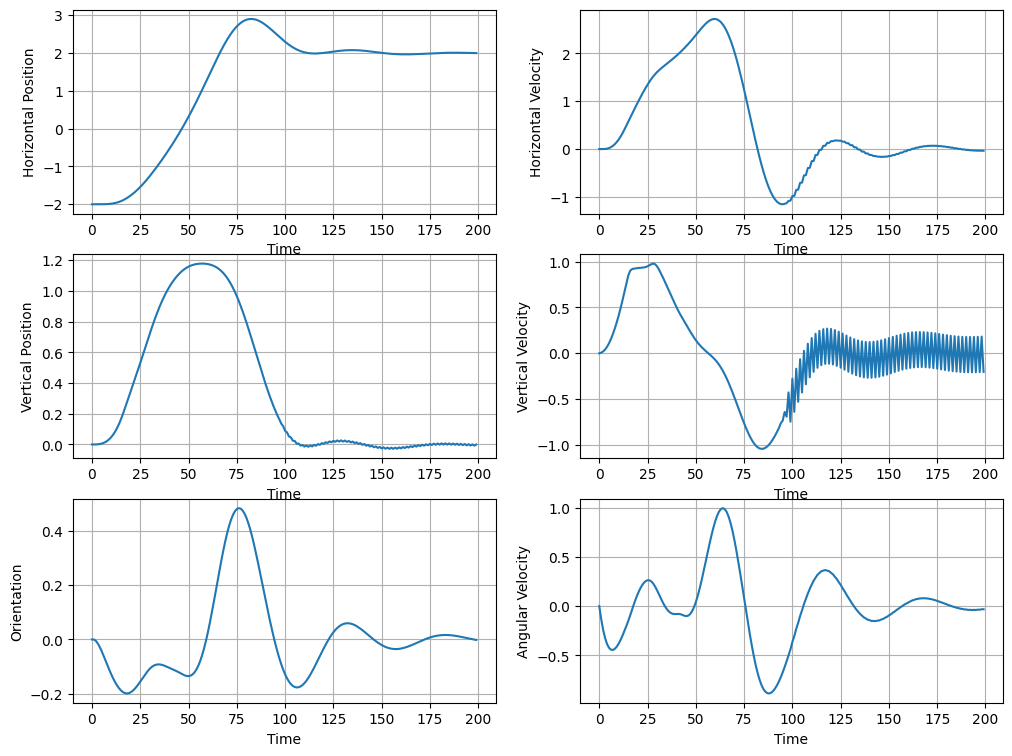

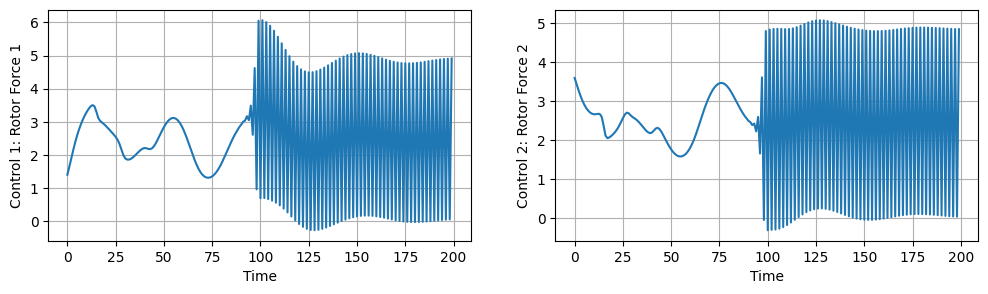

In [19]:
#Plot trajectory
x_vals = np.array(x_vals)
u_vals = np.array(u_vals)

plt.figure(figsize=[12,9])
plt.subplot(3,2,1)
plt.xlabel('Time')
plt.ylabel('Horizontal Position')
plt.plot(x_vals[:,0])
plt.grid()
plt.subplot(3,2,2)
plt.xlabel('Time')
plt.ylabel('Horizontal Velocity')
plt.plot(x_vals[:,1])
plt.grid()
plt.subplot(3,2,3)
plt.xlabel('Time')
plt.ylabel('Vertical Position')
plt.plot(x_vals[:,2])
plt.grid()
plt.subplot(3,2,4)
plt.xlabel('Time')
plt.ylabel('Vertical Velocity')
plt.plot(x_vals[:,3])
plt.grid()
plt.subplot(3,2,5)
plt.xlabel('Time')
plt.ylabel('Orientation')
plt.plot(x_vals[:,4])
plt.grid()
plt.subplot(3,2,6)
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.plot(x_vals[:,5])
plt.grid()

plt.figure(figsize=[12,3])
plt.subplot(1,2,1)
plt.plot(u_vals[:,0])
plt.xlabel('Time')
plt.ylabel('Control 1: Rotor Force 1')
plt.grid()
plt.subplot(1,2,2)
plt.plot(u_vals[:,1])
plt.xlabel('Time')
plt.ylabel('Control 2: Rotor Force 2')
plt.grid()



In [ ]:
# To continue training later, run this block:
model = PPO.load("Quadrotor_Navigation")

**Notes**

- Gave better results when the total timesteps was set to 1 million, though by principle higher timesteps should give better results, so feel free to change.
- Seeding will help in reproducibility 
- Try to ease computing wherever possible
- The graphs in the pdf and ipynb differs because the ipynb file has been optimised further to get a smoother landing with reduced jerking